miny 6956992.566403601
maxy 7067367.635247394


C:\Users\Paddy\AppData\Local\Temp\ipykernel_63112\777401408.py:194: UserWarning: No contour levels were found within the data range.
  plt.contour(x_grd,y_grd,dens_grd,colors='DarkGreen')


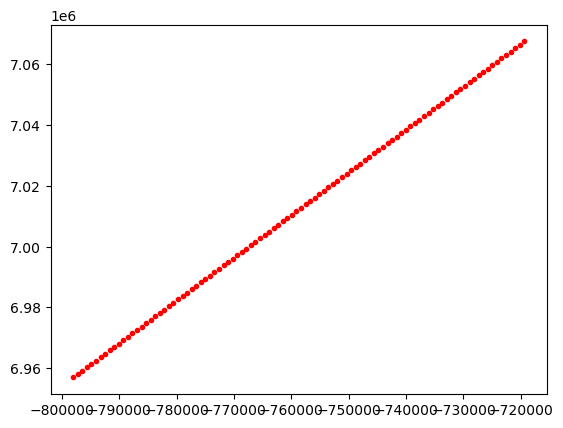

In [54]:
import random
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import random

from shapely.geometry import box
from shapely.ops import triangulate
from shapely.ops import cascaded_union
from shapely.ops import unary_union

from scipy.stats import multivariate_normal

from sklearn.cluster import KMeans
from geovoronoi import voronoi_regions_from_coords, points_to_coords

import matplotlib.pyplot as plt

def poly_bb(polygon):
    minx, miny, maxx, maxy = polygon.total_bounds
    bbox = box(minx, miny, maxx, maxy, ccw=True)
    return gpd.GeoSeries(bbox)

def poly_bb_ratio(polygon):
    bb = poly_bb(polygon)
    return float(1/(polygon.area/bb.area))

def point_in_triangle(poly_tri):
    v1, v2, v3 = poly_tri.exterior.coords[0:3]
    v2_scaled = [v2[0] - v1[0], v2[1] - v1[1]]
    v3_scaled = [v3[0] - v1[0], v3[1] - v1[1]]
    
    s, t = random.uniform(0,1), random.uniform(0,1)
    if s+t > 1:
        s = 1 - s
        t = 1 - t
    two_weighted = [v2_scaled[0] * s, v2_scaled[1] * s]
    three_weighted = [v3_scaled[0] * t, v3_scaled[1] * t]

    new_point = np.add(np.add(two_weighted, three_weighted), [v1[0], v1[1]])
    
    return shapely.Point(new_point)

def point_in_bb(minx, miny, maxx, maxy):
    return shapely.Point([random.uniform(minx, maxx), random.uniform(miny, maxy)])

def uniform_pip(polygon, points):
    minx, miny, maxx, maxy = polygon.total_bounds
    
    points_list = gpd.GeoDataFrame(pd.DataFrame([point_in_bb(minx, miny, maxx, maxy) for i in range(round(points * poly_bb_ratio(polygon)))], columns=['geometry']), geometry='geometry', crs=polygon.crs)

    points_list = points_list.sjoin(polygon, predicate='within')
    if(len(points_list) > points):
        return points_list[0:points]
    return points_list

def kmeans_centroids(poly, num_points, num_cluster):
    source = uniform_pip(poly, num_points)
    feature_coords = np.array([[e.x, e.y] for e in source.geometry])
    kmeans = KMeans(num_cluster, n_init='auto')
    kmeans.fit(feature_coords)
    centroids = kmeans.cluster_centers_
    df = pd.DataFrame(centroids, columns=['x', 'y'])
    return gpd.GeoDataFrame([], geometry=gpd.points_from_xy(df.x, df.y), crs=source.crs)
     

def voronoi_gen(poly, vor_num):
    # Voronoi centroids are generated based on the specified generation type
    vor_centroids = kmeans_centroids(poly, 500, vor_num)

    # Setting crs to meter based projection
    gdf_proj = vor_centroids.set_crs(poly.crs)

    # Convert the boundary geometry into a union of the polygon
    boundary_shape = unary_union(poly.geometry)
    coords = points_to_coords(gdf_proj.geometry)

    region_polys, _ = voronoi_regions_from_coords(coords, boundary_shape)
    # Create GeoDataFrame of the Voronoi Polygons

    gdf_poly = gpd.GeoDataFrame(pd.DataFrame({'geometry': list(region_polys.values())}), geometry='geometry', crs=poly.crs)

    return gdf_poly

def dist_calc_poly(poly, tris):
    tris['dist_to_centre'] = 0
    p = poly.centroid
    for i, tri in enumerate(tris['geometry']):
        current = tri.centroid.distance(shapely.geometry.Point(p.x, p.y))
        tris.loc[i, 'dist_to_centre'] = current

    # Assign a class to each polygon based on the distance to centroid
    # This will produce five distinct regions centred around the given moving/original centroid


    max_dist, min_dist = max(tris['dist_to_centre']), min(tris['dist_to_centre'])
    dist_break = (max_dist - min_dist) / 5
    tris['class'] = 0
    tris = tris.sort_values(by='dist_to_centre')
    tris['class'] = pd.cut(tris['dist_to_centre'], [0, dist_break, dist_break*2, dist_break*3, dist_break*4, np.inf], labels=[1,2,3,4,5])

    return tris

def polys_to_tri(polys):
    poly_list = []
    for poly in polys:
        poly_list += triangulate(poly)

    return gpd.GeoDataFrame(pd.DataFrame(poly_list, columns=['geometry']), geometry='geometry') 

def points_in_tris(tris, points):
    points_list = []    
    for i in range(points):
        points_list.append(point_in_triangle(random_poly(tris)))
        
    return gpd.GeoDataFrame(pd.DataFrame(points_list, columns=['geometry']), geometry='geometry')

def class_dist(tris):
    cum_dist = []
    max_class = sum(tris['class'])
    for i in range(len(tris)):
        if i > 0:
            last_value = cum_dist[i-1]
        else:
            last_value = 0
        cum_dist.append(last_value + (tris['class'][i] / max_class))
    return cum_dist

def random_poly(polys):
    cum_dist = class_dist(polys)
    poly_index = [i for i in range(len(polys))]
    index = random.choices(poly_index, weights=list(polys['class']), k=1)    
    x = polys.loc[index, 'geometry'].reset_index(drop=True)
    return x[0]
    
def pip(dir):
    poly_source = gpd.read_file(dir)
    poly_source = poly_source.to_crs(epsg=3857)
    fig, axs = plt.subplots(1,2, figsize=(8, 5))

    fig.tight_layout()
    fig.suptitle(f"Points in polygon testing")

    poly_source_tri = gpd.GeoSeries(triangulate(poly_source.iloc[0][0]))
    poly_source_bb = poly_bb(poly_source)
    poly_source_bb_tri = gpd.GeoSeries(triangulate(poly_source_bb[0]))

    voronoi_polys = voronoi_gen(poly_source, 128)
    voronoi_tri = polys_to_tri(list(voronoi_polys['geometry']))

    voronoi_tri = dist_calc_poly(poly_source, voronoi_tri)
    voronoi_tri_points = points_in_tris(voronoi_tri, 500)

    for ax in axs:
        ax.axis("off")
        poly_source.plot(ax=ax, edgecolor='green', facecolor='none')
        poly_source_bb.plot(ax=ax, edgecolor='red', facecolor='none')
        
    #poly_source_bb_tri.plot(ax=axs[0], edgecolor='purple', facecolor='none')
    voronoi_polys.plot(ax=axs[0], edgecolor='red', cmap='Blues')
    voronoi_tri.plot(ax=axs[1], edgecolor='none', cmap='Blues', column='class')
    voronoi_tri_points.plot(ax=axs[1], color='red', markersize=5)

    plt.show()

    print("Number of triangles: ", len(voronoi_tri))

def f(x, y):
    return np.sin(x) ** 10 + np.cos(y) ** 10

import scipy.stats as st

def multivar_poly(dir):
    poly_source = gpd.read_file(dir)
    poly_source = poly_source.to_crs(epsg=3857)

    minx, miny, maxx, maxy = poly_source.total_bounds
    print("miny", miny)
    print("maxy", maxy)

    x = np.linspace(minx, maxx, 100)
    y = np.linspace(miny, maxy, 100)
    
    f_hat = st.gaussian_kde([x,y])

    x_grd, y_grd = np.meshgrid(np.linspace(-780000,-740000,100), np.linspace(6980000,7040000,100))

    dens_grd = np.zeros_like(x_grd)
    for i in range(len(x_grd)):
        for j in range(len(y_grd)):
            dens_grd[i,j] = f_hat([x_grd[i,j],y_grd[i,j]])

    plt.contour(x_grd,y_grd,dens_grd,colors='DarkGreen')

    #X, Y = np.meshgrid(x,y)
    #Z = f(X, Y)

    #plt.contour(X, Y, Z, 10, cmap='RdGy')

    plt.scatter(x, y, color='r', marker='.')



#pip("scenarios/kildare/kildare.geojson")
multivar_poly("scenarios/kildare/kildare.geojson")


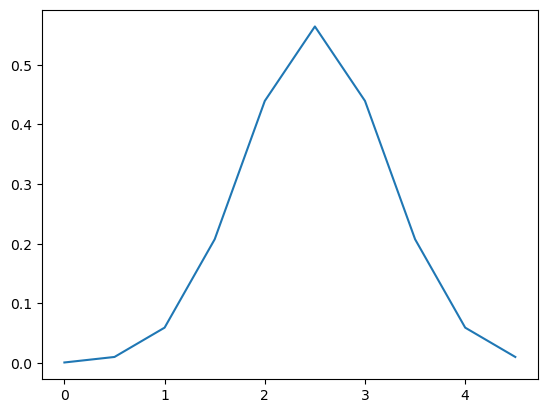

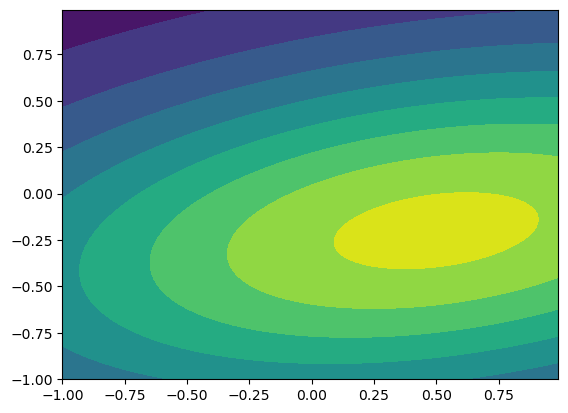